In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 25848 files belonging to 11 classes.


In [8]:
class_names=dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [10]:
len(dataset)

808

In [12]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[5 4 2 0 2 7 8 3 6 4 7 4 2 4 7 9 2 5 7 3 9 8 1 3 3 3 4 4 5 7 0 6]


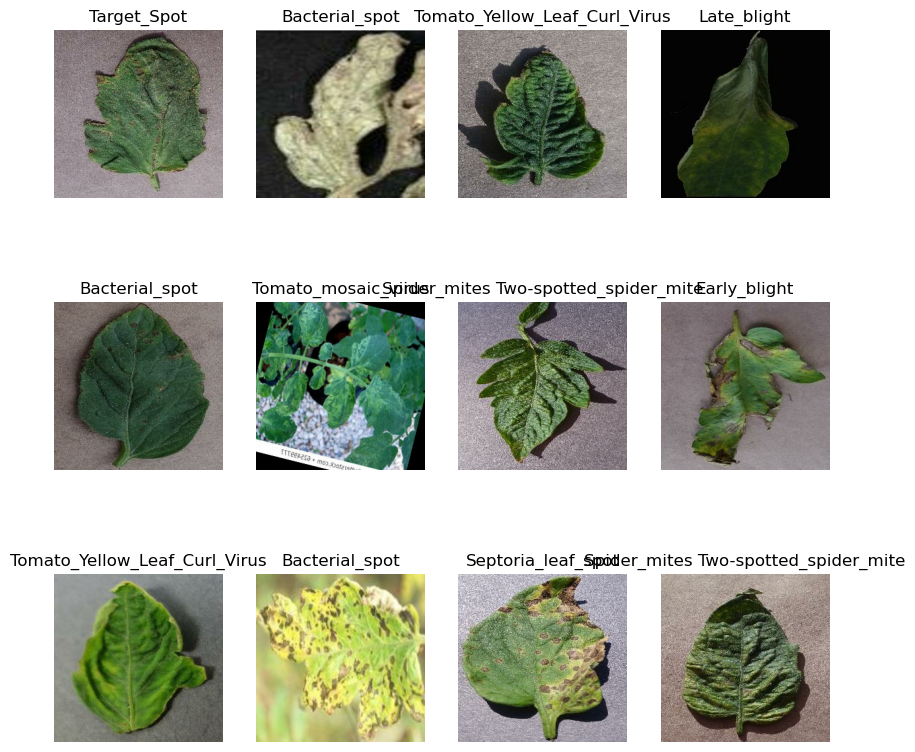

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
#*80% ==>training,
#0% ==>10% validation, 10% test

In [16]:
train_size=0.8
len(dataset)*train_size

646.4000000000001

In [18]:
train_ds=dataset.take(54)
len(train_ds)

54

In [20]:
test_ds=dataset.skip(54)
len(test_ds)

754

In [22]:
val_size=0.1
len(dataset)*val_size

80.80000000000001

In [24]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [26]:
test_ds=test_ds.skip(6)
len(test_ds)

748

In [28]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds,val_ds,test_ds

In [30]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [32]:
len(train_ds)

646

In [34]:
len(val_ds)

80

In [36]:
len(test_ds)

82

In [38]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale =tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [42]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_andvertical"),
    layers.RandomRotation(0.2),
])

In [44]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,

    #1st Layer
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    # 2nd Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Sulochana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 50176)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,599,939 (13.73 MB)

 Trainable params: 3,599,939 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
   train_ds,
   epochs=EPOCHS,
   batch_size=BATCH_SIZE,
   verbose=1,
   validation_data=val_ds
)

Epoch 1/50
